In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import scipy
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import pyslha
import ROOT
import xml.etree.ElementTree as ET


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']
# cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


In [2]:
pclFiles = {'pp->zp': '../data/2mdm_zp_prod.pcl', 
            'pp->y0': '../data/2mdm_y0_prod.pcl',
            'pp->h2': '../data/2mdm_h2_prod.pcl'}
# xsecFiles = {'pp->zp': '../data/2mdm_zp_prod2.txt',
#              'pp->y0': '../data/2mdm_y0_prod.txt',
#              'pp->h2': '../data/2mdm_h2_prod.txt'}

# xsec = {}
# for label, f in xsecFiles.items():
#     xsecArr = np.genfromtxt(f, skip_header=1)
#     xsec[label] = xsecArr[:, 2].flatten()
    
df = [pd.read_pickle(f) for l, f in pclFiles.items()]

df[2]['process'] = 'pp->h2'
df[2] = df[2].drop(columns=['$m_{med}$'])
df[2] = df[2].rename(columns={'$m_{s}$': '$m_{med}$'})
    
for d in df:
    d = d.sort_values(['$m_{med}$', '$\sin\\theta$', '$g_{q}$'],inplace=True, 
                     ascending=[True, True, True])

    
# data.sort_values(['process', '$m_{zp}$', 'x-sec (pb)', '$\Gamma_{zp}$', '$g_{q}$', '$g_{\chi}$'], 
#                   inplace=True, ascending=[True,True,True,True,True,True])

In [3]:
df[1]

,process,$m_{med}$,$\Gamma_{s}$,$m_{\chi}$,$g_{\chi}$,$g_{q}$,$\sin\theta$,Events,x-sec (pb)
0,pp->y0,130.0,0.001109,65.0,0.1,1.0,0.1,15000,0.130493
1,pp->y0,130.0,0.001109,65.0,0.5,1.0,0.1,15000,0.13054
2,pp->y0,130.0,0.001109,65.0,1.0,1.0,0.1,15000,0.13065
3,pp->y0,130.0,0.001109,65.0,2.0,1.0,0.1,15000,0.13083
4,pp->y0,130.0,0.001109,65.0,0.1,1.0,0.2,15000,0.52255
...,...,...,...,...,...,...,...,...,...
70,pp->y0,2000.0,324.5364,65.0,2.0,1.0,0.1,15000,0.000003
71,pp->y0,2000.0,12.3734,65.0,0.1,1.0,0.2,15000,0.000014
72,pp->y0,2000.0,31.35108,65.0,0.5,1.0,0.2,15000,0.000014
73,pp->y0,2000.0,90.65634,65.0,1.0,1.0,0.2,15000,0.000014


In [4]:
# data = df[0]

# for val in data.values:
#     for val in list(df[0]['process']):
#         data['x-sec (pb)'] = xsec[val]
        

# for d in df:
#     for label, f in pclFiles.items():
#         d['x-sec (pb)'] = xsec[label]
#         data = pd.concat((data, df)) 

In [5]:
# data = pd.DataFrame()
# for i, d in enumerate(df):
#     for val in list(d['process']):
#         d['x-sec (pb)'] = xsec[val]
        
#     data = pd.concat((data, d)) 

In [6]:
data = pd.DataFrame()
for d in df:
    data = pd.concat((data,d))

In [7]:
# Filter model

modelFilter = {
#                '$g_{q}$' : 0.1,
               '$g_{\chi}$': 1.0,
               '$\sin\\theta$': 0.1
               }

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in modelFilter.items()])
dfModel = data.loc[(data[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]
textstr2 = '\n$g_{q}$ = 0.1'
textstr = textstr+textstr2

In [8]:
dfModel = dfModel[(dfModel['$g_{q}$'] == 0.1) | (dfModel['$g_{q}$'] == 1.0)]
dfModel = dfModel.drop(columns=['$m_{s}$', '$m_{\chi}$'])

In [9]:
dfModel

,process,$m_{med}$,$\Gamma_{zp}$,$\Gamma_{s}$,$g_{\chi}$,$g_{q}$,$\sin\theta$,Events,x-sec (pb)
2,pp->zp,500.0,4.232106,0.095732,1.0,0.1,0.1,15000,46.282994
108,pp->zp,600.0,5.595495,0.091721,1.0,0.1,0.1,15000,23.771984
284,pp->zp,700.0,6.902694,0.090695,1.0,0.1,0.1,15000,13.302575
367,pp->zp,800.0,8.171828,0.090702,1.0,0.1,0.1,15000,7.938617
383,pp->zp,900.0,9.414265,0.091075,1.0,0.1,0.1,15000,4.95366
...,...,...,...,...,...,...,...,...,...
113,pp->h2,1500.0,10.63738,20.33561,1.0,0.1,0.1,15000,0.00003
131,pp->h2,1600.0,10.63738,24.63761,1.0,0.1,0.1,15000,0.000019
148,pp->h2,1700.0,10.63738,29.51468,1.0,0.1,0.1,15000,0.000012
166,pp->h2,1800.0,10.63738,35.01375,1.0,0.1,0.1,15000,0.000008


In [10]:
colors = {label : sns.color_palette('deep', n_colors=16)[i] for i,label in enumerate(pclFiles.keys())}    

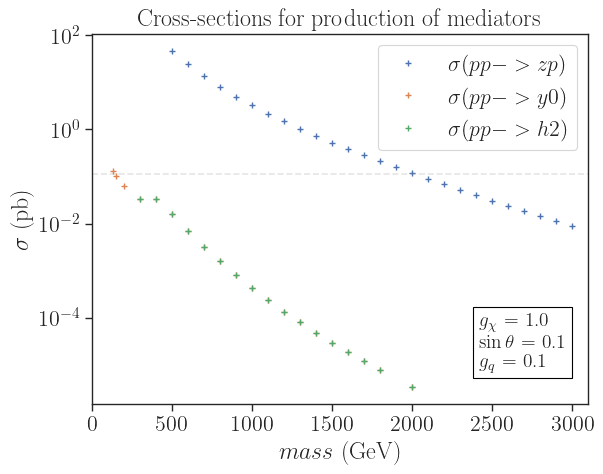

In [11]:
# plot cross-section

for label in pclFiles.keys():
    mass = np.array(dfModel['$m_{med}$'][dfModel['process'] == label])
    xsecs = np.array(dfModel['x-sec (pb)'][dfModel['process'] == label])
    plt.plot(mass, xsecs, color=colors[label], marker='+', linestyle='', label=r'$\sigma(%s)$' %(label))

    
plt.hlines(0.11, xmin=0.0, xmax=3100, linestyles='--', alpha=0.2, color='gray')
plt.yscale('log')

plt.title('Cross-sections for production of mediators')
plt.xlabel(r'$mass$ (GeV)')
plt.ylabel(r'$\sigma$ (pb)')

plt.text(0.78,0.1,textstr,fontsize=14,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
plt.xlim(0.0, 3100)

plt.legend()
plt.show()

In [12]:
dfModel[dfModel['process'] == 'pp->y0']

,process,$m_{med}$,$\Gamma_{zp}$,$\Gamma_{s}$,$g_{\chi}$,$g_{q}$,$\sin\theta$,Events,x-sec (pb)
2,pp->y0,130.0,NaN,0.001109,1.0,1.0,0.1,15000,0.13065
30,pp->y0,150.0,NaN,0.742889,1.0,1.0,0.1,15000,0.10196
79,pp->y0,200.0,NaN,3.49739,1.0,1.0,0.1,15000,0.061629
87,pp->y0,300.0,NaN,8.757618,1.0,1.0,0.1,15000,0.033685
95,pp->y0,400.0,NaN,13.54384,1.0,1.0,0.1,15000,0.032779
103,pp->y0,500.0,NaN,18.12684,1.0,1.0,0.1,15000,0.015961
111,pp->y0,600.0,NaN,22.5879,1.0,1.0,0.1,15000,0.007101
119,pp->y0,700.0,NaN,26.98859,1.0,1.0,0.1,15000,0.003266
127,pp->y0,800.0,NaN,31.36655,1.0,1.0,0.1,15000,0.001585
135,pp->y0,900.0,NaN,35.74628,1.0,1.0,0.1,15000,0.000811


In [13]:
dfModel[dfModel['process'] == 'pp->zp']

,process,$m_{med}$,$\Gamma_{zp}$,$\Gamma_{s}$,$g_{\chi}$,$g_{q}$,$\sin\theta$,Events,x-sec (pb)
2,pp->zp,500.0,4.232106,0.095732,1.0,0.1,0.1,15000,46.282994
108,pp->zp,600.0,5.595495,0.091721,1.0,0.1,0.1,15000,23.771984
284,pp->zp,700.0,6.902694,0.090695,1.0,0.1,0.1,15000,13.302575
367,pp->zp,800.0,8.171828,0.090702,1.0,0.1,0.1,15000,7.938617
383,pp->zp,900.0,9.414265,0.091075,1.0,0.1,0.1,15000,4.95366
399,pp->zp,1000.0,10.63738,0.091565,1.0,0.1,0.1,15000,3.206695
415,pp->zp,1100.0,11.84611,0.092071,1.0,0.1,0.1,15000,2.143731
26,pp->zp,1200.0,13.04388,0.092555,1.0,0.1,0.1,15000,1.46418
44,pp->zp,1300.0,14.23311,0.093002,1.0,0.1,0.1,15000,1.021215
61,pp->zp,1400.0,15.41556,0.09341,1.0,0.1,0.1,15000,0.727612
